In [40]:
import os
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as np
from jax.numpy.linalg import norm
from jax import grad, jit, vmap
from dataclasses import dataclass
import datetime
from functools import partial

In [41]:
@dataclass
class pre_process:
    data: pd.DataFrame
    diff: int # diff > 0
        
    def __repr__(self):
        return "Nested list processed S&P 500 data"
    
    def __post_init__(self):
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.windows = self.process_data()
        
    def process_data(self):
        dates = self.data['date'].unique()
    
        # dropping symbols that aren't traded every day
        count = self.data.groupby('Name').count()['date']
        bad_symbols = count[count < len(dates)].index.tolist()
        subset = self.data.query('Name == @bad_symbols')
        self.data.drop(subset.index, axis = 'index', inplace = True)
        self.symbols = self.data['Name'].unique()

        # calculating log returns
        returns = self.data.groupby('Name')['close'].apply(lambda x: onp.diff(onp.log(x), self.diff)).apply(pd.Series).T
        returns.set_index(dates[self.diff:], inplace = True)
        self.returns = returns
        
    def plot(self, symbol, col = 'close', dt_range = None):
        if dt_range == None:
            t0 = self.data['date'].min()
            t1 = self.data['date'].max()
        else:
            t0, t1 = pd.to_datetime(dt_range)
        df = self.data.query('Name == @symbol and date >= @t0 and date <= @t1')
        plt.figure(figsize = (13,5))
        plt.plot(df['date'].values, df[col], linewidth = 2)
        plt.title(f'Symbol: {symbol}')
        plt.show()

In [198]:
@dataclass
class FusedLasso:
    data: pd.DataFrame
        
    def __post_init__(self):
        self.cols = self.data.columns
        self.N = len(self.data)
        self.p = len(self.data.columns)-1

        # params for armijo line-search and optimization error
        self.alpha = .3
        self.gamma = .5

    def apply_matrix(self, b, X, y):
      return norm(y-np.matmul(X, b), 2)**2

    def lasso(self, BETA):
      return norm(BETA, 1)

    def fused_lasso(self, BETA):
      b = BETA.reshape(self.N, self.p)
      return np.sum(np.abs(np.diff(b.T)))

    def mse(self, BETA, X, y):
      b = BETA.reshape(self.N, self.p)
      _apply_matrix = partial(self.apply_matrix, X = X, y = y)
      return np.sum(vmap(_apply_matrix)(b))

    def penalty(self, BETA, L1, L2):
      return L1*self.lasso(BETA) + L2*self.fused_lasso(BETA)

    def obj_func(self, BETA, X, y, L1, L2):
      return self.mse(BETA, X, y) + self.penalty(BETA, L1, L2)

    def nesterov(self, B_List, k):
      return B_List[-1] + (k-2)/(k+1)*(B_List[-1]-B_List[-2])

    def line_search(self, V_k, dBeta, L1, L2, X, y):
      t = 1
      func = partial(self.obj_func, L1 = L1, L2 = L2, X = X, y = y)
      while func(V_k-t*dBeta) > func(V_k) - self.alpha*t*norm(dBeta, 2)**2:
        t*=self.gamma
      return t

    def relative_error(self, MSE_List):
      return np.abs(MSE_List[-1]-MSE_List[-2])/MSE_List[-1]

    def fit(self, X, y, L1, L2):
      k = 0 
      MSE_List = []
      BETA_List = [onp.random.normal(0, 1, self.N*self.p) for i in range(2)] 
      partial_obj = partial(self.obj_func, L1=L1, L2=L2, X=X, y=y)
      partial_armijo = partial(self.line_search, L1=L1, L2=L2, X=X, y=y)

      while True:
        V_k =  self.nesterov(BETA_List, k)
        dBeta = grad(partial_obj)(V_k)
        t_k = partial_armijo(V_k, dBeta) 
        B_k = V_k-t_k*dBeta
        BETA_List.append(B_k)
        MSE_List.append(self.mse(B_k, X, y))
        k+=1

        if k > 3:
          del BETA_List[-3] #, MSE_List[-3]
          if self.relative_error(MSE_List) < .1:
            return BETA_List[-1], MSE_List
        elif k > 50:
          AssertionError('Diverges, adjust acceleration params.')

In [226]:
data = pd.read_csv(os.getcwd()+'/all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [267]:
large_cap = data.groupby('Name').sum('volume').sort_values(by = ['volume'], ascending = False)['volume']
large_cap.head(10)

Name
BAC     117884953591
AAPL     68046305767
GE       53023644686
F        43388129992
FB       43258314899
MSFT     42641653597
AMD      40941468586
MU       38082749687
INTC     36922332801
CSCO     36075826186
Name: volume, dtype: int64

Getting the symbols with the highest trading volume

In [228]:
sp = pre_process(data, diff = 1)
returns = sp.returns
returns.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,ANDV,ANSS,...,URI,USB,UTX,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAT,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-11,-0.010705,-0.019857,-0.006485,0.010368,-0.011096,-0.002776,-0.004369,-0.003279,-0.012346,0.008281,0.001983,-0.009648,-0.004293,0.000000,0.007028,0.003583,0.011675,-0.004357,-0.001789,-0.009075,0.016872,0.012176,-0.002077,-0.002373,-0.003110,0.001595,0.009124,0.002667,0.002434,-0.014627,0.003667,0.030421,0.001205,-0.006027,-0.021551,0.000000,-0.008863,-0.018261,0.012730,0.000268,...,0.004323,0.012991,-0.005342,-0.009359,0.000141,-0.006161,0.000506,0.000217,-0.007697,0.003426,-0.005113,0.005931,-0.006543,0.004144,-0.000677,-0.000649,0.001931,0.002266,0.001995,0.010836,-0.007952,0.000275,-0.007248,-0.001120,-0.028366,-0.002320,-0.004518,-0.019313,0.002250,0.003586,0.002476,-0.001334,-0.003731,-0.000700,0.003762,0.013566,-0.011552,-0.002640,0.002896,0.006334
2013-02-12,0.000448,-0.013227,0.002675,-0.025386,-0.012067,0.004268,0.001167,0.004097,0.006449,0.004115,0.017352,0.000331,-0.007196,0.000514,0.009395,0.003793,0.009774,-0.004576,-0.015237,-0.010207,-0.021005,0.008265,0.064652,-0.001585,0.039700,-0.000956,-0.000303,0.001229,0.007924,-0.022904,0.000000,0.036769,0.007440,0.001236,-0.004485,0.014928,-0.010397,0.005776,-0.019623,0.013692,...,0.018213,0.006433,0.004121,0.003002,0.003510,0.003872,-0.003209,-0.010677,0.008410,0.009039,-0.007166,-0.002851,0.004149,0.006772,0.002704,-0.005204,0.011267,-0.008680,-0.005245,0.007065,0.039954,0.004123,0.002794,0.000000,0.006296,0.005624,0.000000,-0.011590,0.003738,0.002145,0.003526,0.003198,0.002037,0.000700,-0.003762,0.017687,0.003094,-0.002780,0.011499,0.014329
2013-02-13,0.002909,0.026963,0.004696,-0.001905,-0.004244,-0.006838,0.004654,0.002586,-0.002059,-0.000216,0.011296,0.001490,0.000000,-0.006446,0.003914,0.000668,0.002649,-0.012844,-0.017321,0.011014,0.006194,-0.008956,0.008248,0.018859,0.015395,0.053563,-0.008210,0.013418,0.005902,0.019757,0.008020,-0.007246,0.004295,0.004928,0.004720,0.005909,-0.021259,0.040788,0.010785,0.001979,...,0.021679,-0.011137,-0.005349,-0.013031,0.001960,-0.002360,0.007247,0.012842,-0.004644,0.000234,0.006250,0.001098,0.012775,-0.000734,0.001799,0.013282,-0.011267,0.009297,-0.002256,-0.010759,0.001533,0.004925,-0.005596,-0.000140,-0.011926,0.005593,-0.009607,-0.002203,0.011132,-0.002861,0.000352,0.005837,0.002371,0.004887,0.005013,0.011030,-0.005265,0.007396,0.010156,-0.005647
2013-02-14,-0.003806,-0.046780,-0.001648,-0.000900,0.036195,0.002783,0.006940,-0.005863,-0.005167,0.006035,0.007673,0.004786,0.000328,0.000259,-0.004216,-0.003567,-0.011530,0.001009,0.003693,-0.002771,0.008709,0.002419,0.014868,0.007239,0.014898,-0.011250,-0.005818,-0.016492,0.000000,-0.048774,0.008677,0.000000,-0.002145,0.005922,-0.002593,0.016797,-0.007052,-0.000854,0.020321,-0.005020,...,0.007362,0.001767,0.002121,0.007788,-0.007581,0.003210,0.006695,0.021184,-0.017882,-0.006447,-0.005513,0.001973,-0.017799,-0.004857,-0.004277,0.002678,0.009119,0.003695,-0.009837,0.002275,0.000180,0.013554,-0.005063,-0.008016,-0.002119,-0.001313,-0.003733,0.006515,-0.007407,-0.001075,-0.007062,0.016789,-0.001693,-0.003954,0.003743,0.007404,-0.008106,0.004464,-0.004456,-0.008381
2013-02-15,-0.053681,0.035806,0.002027,-0.013876,0.027244,-0.003641,0.010891,0.013986,0.000647,-0.007874,0.036584,0.007871,0.019755,0.008498,-0.000302,0.008009,-0.003575,-0.007290,0.010390,-0.014558,-0.022177,0.005164,-0.004055,0.001287,0.016239,0.000153,0.005208,0.005528,-0.000654,-0.018660,-0.010858,-0.014652,0.000000,-0.005649,-0.013189,-0.003918,0.022872,-0.015534,-0.009834,0.001456,...,-0.018598,-0.002356,0.012080,0.012804,-0.012907,0.032641,-0.008207,0.001270,0.002912,-0.001765,0.011177,0.010239,-0.001096,0.024628,0.001578,-0.009243,-0.017107,-0.004517,0.008330,-0.001421,0

In [229]:
print('(Trading Days, Num Stocks) =', returns.shape)

(Trading Days, Num Stocks) = (1258, 470)


Next step is to add a new method that calls .fit() for each stock. Because I do not have that yet but want to demonstrate nesterov accelerated gradient descent in JAX, I construct X and y outside of the class.

In [266]:
symbol_subset = large_cap.index[:15]
returns_subset = returns.loc[:, symbol_subset]

symbol_y = symbol_subset[7]
symbol_X = [s for s in symbol_subset if s != symbol_y] # selected arbitrarily for demonstration.
print(f"y = {symbol_y} | X = {symbol_X[:10]}...")

y = returns_subset.loc[:, symbol_y].values
X = returns_subset.loc[:, symbol_X].values

N,p = X.shape


y = MU | X = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'INTC', 'CSCO', 'PFE']...


(1258, 14)

This is not regular lasso regression, this is a fused lasso. Not only are the parameters being regularized but they are being smoothed. For every set of observations I am estimating the linear relationships between all of the stocks and assuming that these relationships are not instantaneous and persist for some TBD time (via crossval). Not disclosing *exactly* what I am doing with these parameters but I am interested in analyzing the market as evolving graph/network and being able to understand large scale conditional indpendence structures. 

Consider that the market is in state A and has an 80% probability of evolving to state B within the next 3 days. This would offer a novel way to price options that factors in expected volatility catalyzed by movement in various subsets of the market. These relationships might not be initially apparent through the lens of classical correlation techniques. 

The original Fused Lasso [paper](https://web.stanford.edu/group/SOL/papers/fused-lasso-JRSSB.pdf) by Tibshirani 

These symbols are selected arbitrarily, in practice I would be analyzing the conditional independence structure of the entire S&P-500. Note that this subset of assets is arbitrary as well, same goes for the current time resolution of daily/adj_close.

In [254]:
L1 = 10 # well known lasso penalty
L2 = 10 # 1-norm on the differenced parameters over time, enforces smoothness

model = FusedLasso(returns_subset)
params, MSE_List = model.fit(X, y, L1, L2)

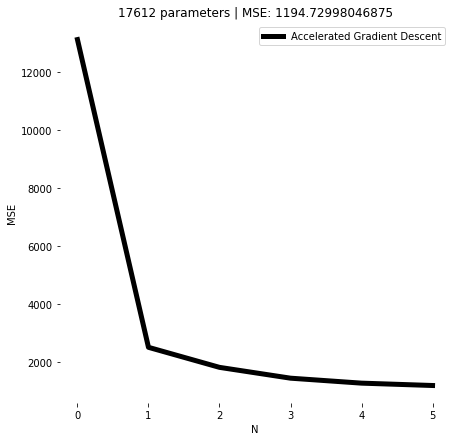

In [255]:
x_vals = list(range(len(MSE_List)))
plt.figure(figsize = (7,7))
plt.plot(x_vals, MSE_List, color = 'k', linewidth = 5, label = 'Accelerated Gradient Descent')
plt.title(f'{N*p} parameters | MSE: {round(min(MSE_List), 2)}')
plt.xlabel('N')
plt.ylabel('MSE')
plt.legend()
plt.box(on=None)
plt.show()

I don't show the data here for cleanliness, but you can assume that the MSE curve of vanilla gradient descent has a similar shape but doesn't converge until something like N=300+. This would be rediculous to compute, luckily the autograd running on the GPU/TPU from JAX makes this slick. Nesterov acceleration with Arimjo backtracking linesearch is incredibly powerful. Just look at how many parameters are being estimated!

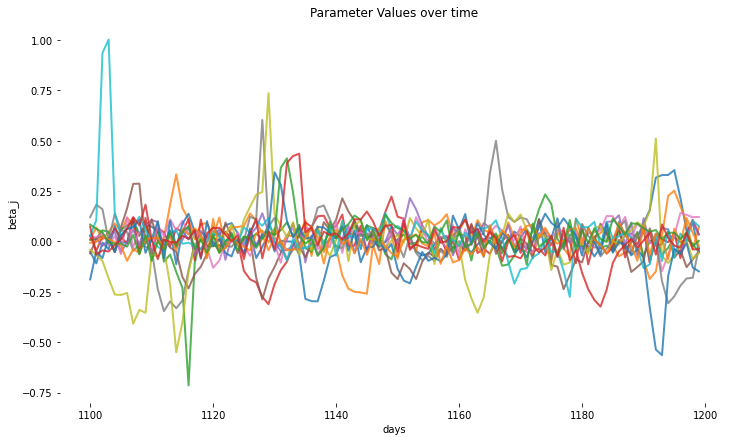

In [265]:
t0, t1 = 1100, 1200

_params = params.reshape(N,p)
plt.figure(figsize = (12,7))
plt.plot(list(range(t0, t1)), _params[t0: t1], alpha = .8, linewidth = 2)
plt.title('Parameter Values over time')
plt.xlabel('days')
plt.ylabel('beta_j')
plt.box(on=None)
plt.show()

In [264]:
print(f"y = {symbol_y} | X = {symbol_X[:10]}...")

y = MU | X = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'INTC', 'CSCO', 'PFE']...


Here we can see that the two green stocks have high predictive power in this case. Note that parameter increase in one of these stocks triggers the other to follow suit. These are the kind of behaviors I am interested in. In this case we are considering pairs, but the dynamics of entire baskets can be analysed and used within a more abstract model that predicts volatility based on market states. Contrast this to a basic correlation matrix, so much is gained here. 

Work needs to be done on getting transaction data from the optimal time scale.